In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import kagglehub
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.utils import resample

In [2]:
# Download the datatset
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

print("Available files:",os.listdir(path))

# Copy and store the dataset in the colab files
shutil.copy(path+'/'+'kidneyData.csv','/content/')
src=path+'/'+'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
shutil.copytree(src, '/content/', dirs_exist_ok=True)

100%|██████████| 1.52G/1.52G [00:19<00:00, 82.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/versions/1
Available files: ['kidneyData.csv', 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone']


'/content/'

In [3]:
# Import the CSV file
df=pd.read_csv('/content/kidneyData.csv')
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [4]:
# Obtaining the information in the CSV file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12446 non-null  int64 
 1   image_id    12446 non-null  object
 2   path        12446 non-null  object
 3   diag        12446 non-null  object
 4   target      12446 non-null  int64 
 5   Class       12446 non-null  object
dtypes: int64(2), object(4)
memory usage: 583.5+ KB


In [5]:
# Count of missing values in each column
df.isnull().sum()

,0
Unnamed: 0,0
image_id,0
path,0
diag,0
target,0
Class,0


In [6]:
# Count of categories present in 'Class' column
df['Class'].value_counts()

,count
Class,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


In [7]:
# Count of categories present in 'target' column
df['target'].value_counts()

,count
target,
1,5077
0,3709
3,2283
2,1377


In [8]:
# Count of categories present in 'diag' column
df['diag'].value_counts()

,count
diag,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


In [9]:
# Create a dataframe consisting the right path to the image and its label
base_dir = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

sub_dirs = ['Tumor', 'Normal', 'Stone', 'Cyst']

data = []

for sub_dir in sub_dirs:
    sub_dir_path = os.path.join(base_dir, sub_dir)
    for image in os.listdir(sub_dir_path):
        if image.endswith('.jpg'):
            image_path = os.path.join(sub_dir_path, image)
            data.append({'image_path': image_path, 'label': sub_dir})

df=pd.concat([df,pd.DataFrame(data)],axis=1)

In [10]:
# Drop the columns that are not required
columns_to_drop=['Unnamed: 0','path','diag','Class']
df.drop(columns_to_drop,axis=1,inplace=True)

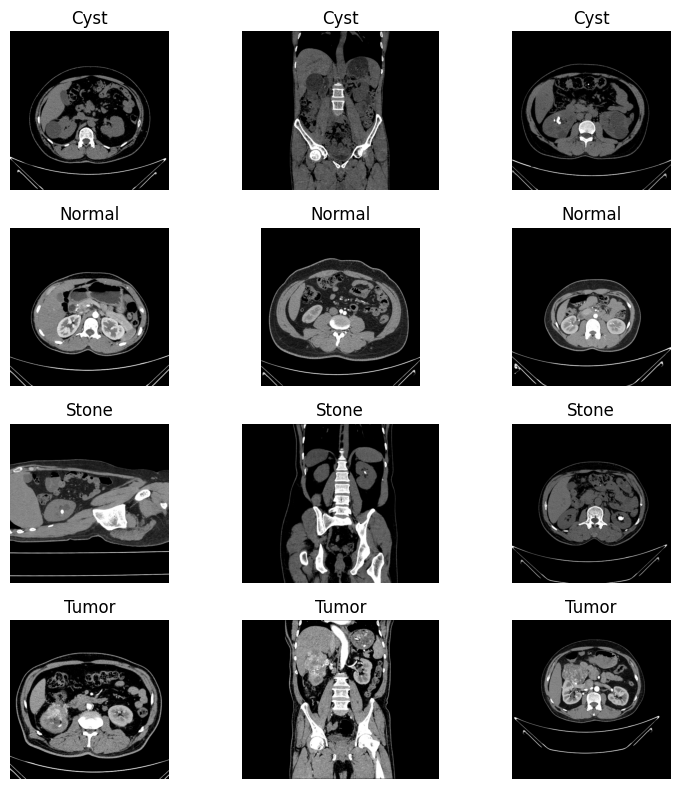

In [11]:
# Display pictures on different classes of the dataset
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']
fig, axes = plt.subplots(4, 3, figsize=(8, 8))
axes = axes.flatten()

for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['image_path']), 3)

    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        axes[i * 3 + j].imshow(img)
        axes[i * 3 + j].axis('off')
        axes[i * 3 + j].set_title(label)
plt.tight_layout()
plt.show()

<ipython-input-12-4b9b9a2e50bc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set3')


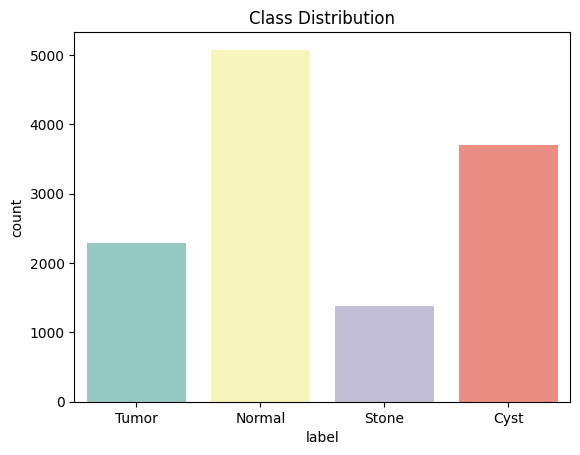

In [12]:
# Compare the count of the 4 classes (tumor, stone, cyst, normal) in a bar chart
sns.countplot(x='label', data=df, palette='Set3')
plt.title('Class Distribution')
plt.show()

In [13]:
# Count of each category of label
class_counts=df['label'].value_counts()
print(class_counts)

# Find the maximum class size
max_size = class_counts.max()

# Separate each class
dfs = {label: df[df['label'] == label] for label in df['label'].unique()}

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


In [14]:
# Define an image augmentation function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

# Augment images in smaller classes
augmented_data = []
for label, data in dfs.items():
    if len(data) < max_size:
        additional_samples = max_size - len(data)
        for i in range(additional_samples):
            original_image_path = random.choice(data['image_path'].tolist())
            img = tf.keras.preprocessing.image.load_img(original_image_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = augment_image(img).numpy()
            augmented_data.append({'image_path': None, 'label': label, 'augmented_image': img})

# Add augmented data to the dataset
augmented_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([df, augmented_df])

label
Tumor     5077
Normal    5077
Stone     5077
Cyst      5077
Name: count, dtype: int64


<ipython-input-15-fae6986c4612>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=balanced_df, palette='Set3')


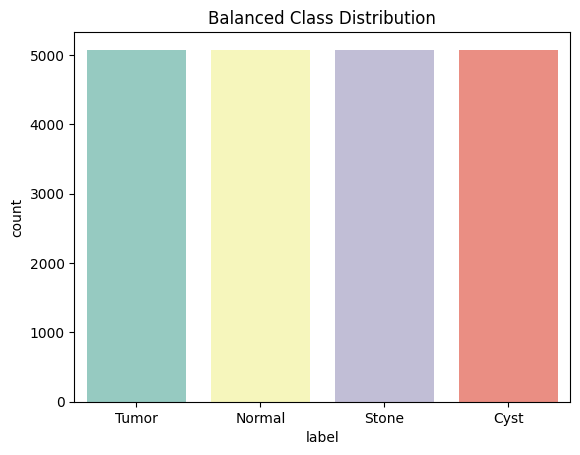

In [15]:
# Check the distribution of classes after balancing
balanced_counts = balanced_df['label'].value_counts()
print(balanced_counts)

# Visualize the new distribution
sns.countplot(x='label', data=balanced_df, palette='Set3')
plt.title('Balanced Class Distribution')
plt.show()

In [16]:
# Split the dataset into train, test and validation sets
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Print the number of samples in each set
print("Training set:")
print(train_df['label'].value_counts())
print("\nValidation set:")
print(val_df['label'].value_counts())
print("\nTest set:")
print(test_df['label'].value_counts())

Training set:
label
Cyst      3554
Tumor     3554
Normal    3554
Stone     3553
Name: count, dtype: int64

Validation set:
label
Stone     762
Cyst      762
Tumor     761
Normal    761
Name: count, dtype: int64

Test set:
label
Stone     762
Normal    762
Tumor     762
Cyst      761
Name: count, dtype: int64


In [17]:
# Image preprocessing
def preprocess_images(df, target_size=(64, 64)):
    images = []
    labels = []
    for _, row in df.iterrows():
        # If it's augmented data
        if row['image_path'] is None:
            img = row['augmented_image']
        else:
            img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0

        # Ensure that the image has the correct shape (64, 64, 3)
        if img.shape != (64, 64, 3):
            img = np.resize(img, (64, 64, 3))

        images.append(img)
        labels.append(row['label'])

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Preprocess datasets
train_images, train_labels = preprocess_images(train_df)
val_images, val_labels = preprocess_images(val_df)
test_images, test_labels = preprocess_images(test_df)

In [18]:
# One-hot encoding of classes in train, test and validation datasets
encoder = LabelEncoder()
train_labels_encoded = to_categorical(encoder.fit_transform(train_labels))
val_labels_encoded = to_categorical(encoder.transform(val_labels))
test_labels_encoded = to_categorical(encoder.transform(test_labels))

In [19]:
# Define CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_images, train_labels_encoded,  # Use one-hot encoded labels
    epochs=10,
    validation_data=(val_images, val_labels_encoded),  # Use one-hot encoded labels
    batch_size=32
)

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 103s 224ms/step - accuracy: 0.5787 - loss: 0.9549 - val_accuracy: 0.8404 - val_loss: 0.3822
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 103s 232ms/step - accuracy: 0.8404 - loss: 0.3752 - val_accuracy: 0.8933 - val_loss: 0.2523
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 140s 227ms/step - accuracy: 0.8938 - loss: 0.2464 - val_accuracy: 0.9064 - val_loss: 0.2168
Epoch 4/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 103s 233ms/step - accuracy: 0.9011 - loss: 0.2188 - val_accuracy: 0.9166 - val_loss: 0.1937
Epoch 5/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 143s 235ms/step - accuracy: 0.9071 - loss: 0.1992 - val_accuracy: 0.9212 - val_loss: 0.1895
Epoch 6/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 99s 223ms/step - accuracy: 0.9169 - loss: 0.1768 - val_accuracy: 0.9215 - val_loss: 0.1850
Epoch 7/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 147s 233ms/step - accuracy: 0.9159 - loss: 0.1779 - val_accuracy: 0.9245 - val_loss: 0.1827
Epoch 8/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 137s 222ms/step - accuracy: 0.9175 - 

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded, verbose=0)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1864
Test Accuracy: 0.9173


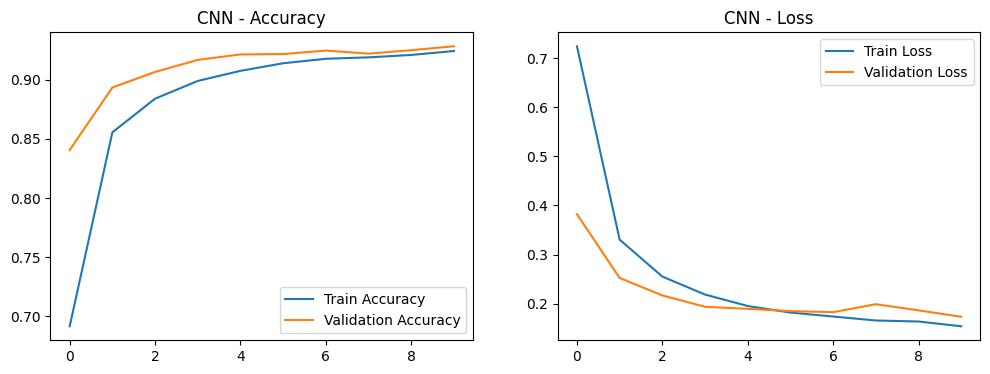

In [22]:
# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()
plot_training_history(history, 'CNN')

In [23]:
model.save("KT_model.h5")